# DistAwareAug vs SMOTE Benchmark

This notebook compares DistAwareAug with SMOTE (Synthetic Minority Oversampling Technique) on various datasets to demonstrate the advantages of distribution-aware augmentation.

## Comparison Metrics:
- **Sample Quality**: Distribution similarity, diversity scores
- **Classification Performance**: Accuracy, F1-score, AUC-ROC
- **Computational Efficiency**: Runtime comparisons
- **Visual Analysis**: Sample distribution plots

In [2]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification, make_blobs, load_breast_cancer, load_wine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from collections import Counter
import time
import sys
import os

# Install imbalanced-learn if not available
try:
    from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
    print("✅ imbalanced-learn found")
except ImportError:
    print("❌ Installing imbalanced-learn...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
    print("✅ imbalanced-learn installed")

# Add parent directory to path to import our package
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in globals() else os.getcwd()
project_root = os.path.dirname(notebook_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")

# Import DistAwareAug
from distawareaug import DistAwareAugmentor
from distawareaug.distance import DistanceMetrics
from distawareaug.utils import check_class_balance

plt.style.use('seaborn-v0_8')
print("✅ All libraries imported successfully!")


✅ imbalanced-learn found
Project root: /Users/admin/Documents/GitHub/DistAwareAug
✅ All libraries imported successfully!


In [3]:
# Define comparison framework
def evaluate_oversampling_method(X_train, y_train, X_test, y_test, method_name, oversampler, classifier):
    """Evaluate an oversampling method with a classifier."""
    
    # Time the oversampling
    start_time = time.time()
    X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)
    oversample_time = time.time() - start_time
    
    # Time the training
    start_time = time.time()
    classifier.fit(X_resampled, y_resampled)
    train_time = time.time() - start_time
    
    # Make predictions
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1] if hasattr(classifier, 'predict_proba') else None
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # AUC-ROC (for binary classification)
    if len(np.unique(y_test)) == 2 and y_pred_proba is not None:
        auc = roc_auc_score(y_test, y_pred_proba)
    else:
        auc = None
    
    # Calculate sample statistics
    original_counts = Counter(y_train)
    resampled_counts = Counter(y_resampled)
    n_synthetic = len(y_resampled) - len(y_train)
    
    return {
        'method': method_name,
        'accuracy': accuracy,
        'f1_score': f1,
        'auc_roc': auc,
        'oversample_time': oversample_time,
        'train_time': train_time,
        'total_time': oversample_time + train_time,
        'n_synthetic': n_synthetic,
        'original_counts': original_counts,
        'resampled_counts': resampled_counts,
        'X_resampled': X_resampled,
        'y_resampled': y_resampled
    }

print("✅ Evaluation framework defined!")

✅ Evaluation framework defined!


In [4]:
# Create synthetic imbalanced dataset
print("Creating synthetic imbalanced dataset...")
np.random.seed(42)

X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    weights=[0.85, 0.15],  # 85% class 0, 15% class 1
    flip_y=0.01,
    random_state=42
)

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Show class distribution
train_counts = Counter(y_train)
test_counts = Counter(y_test)

print(f"\nTraining set distribution:")
for cls, count in train_counts.items():
    print(f"  Class {cls}: {count} samples ({count/len(y_train)*100:.1f}%)")

print(f"\nTest set distribution:")
for cls, count in test_counts.items():
    print(f"  Class {cls}: {count} samples ({count/len(y_test)*100:.1f}%)")

print(f"\nImbalance ratio: {max(train_counts.values()) / min(train_counts.values()):.2f}")


Creating synthetic imbalanced dataset...

Training set distribution:
  Class 0: 591 samples (84.4%)
  Class 1: 109 samples (15.6%)

Test set distribution:
  Class 0: 254 samples (84.7%)
  Class 1: 46 samples (15.3%)

Imbalance ratio: 5.42


## Experiment 1: Synthetic Dataset Comparison

Let's compare all methods on a synthetic imbalanced dataset:
- **SMOTE**: Original SMOTE implementation
- **BorderlineSMOTE**: Focuses on borderline samples
- **ADASYN**: Adaptive Synthetic sampling
- **DistAwareAug (KDE)**: Our method with KDE distributions
- **DistAwareAug (Gaussian)**: Our method with Gaussian distributions


In [5]:
# Initialize all oversampling methods
methods = {
    'SMOTE': SMOTE(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'DistAwareAug (KDE)': DistAwareAugmentor(
        sampling_strategy='auto',
        diversity_threshold=0.1,
        distribution_method='kde',
        random_state=42
    ),
    'DistAwareAug (Gaussian)': DistAwareAugmentor(
        sampling_strategy='auto',
        diversity_threshold=0.1,
        distribution_method='gaussian',
        random_state=42
    )
}

print("✅ All oversampling methods initialized!")
print(f"\nComparing {len(methods)} methods...")


✅ All oversampling methods initialized!

Comparing 5 methods...


In [6]:
# Run comparison with Random Forest classifier
print("Running comparison experiments...")
print("=" * 70)

results = []
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

for method_name, oversampler in methods.items():
    print(f"\n{method_name}:")
    try:
        result = evaluate_oversampling_method(
            X_train, y_train, X_test, y_test,
            method_name, oversampler, classifier
        )
        results.append(result)
        
        print(f"  ✅ Accuracy: {result['accuracy']:.4f}")
        print(f"  ✅ F1-Score: {result['f1_score']:.4f}")
        if result['auc_roc']:
            print(f"  ✅ AUC-ROC: {result['auc_roc']:.4f}")
        print(f"  ⏱️  Oversample time: {result['oversample_time']:.3f}s")
        print(f"  📊 Synthetic samples: {result['n_synthetic']}")
        
    except Exception as e:
        print(f"  ❌ Error: {e}")

print("\n" + "=" * 70)
print("✅ Comparison complete!")


Running comparison experiments...

SMOTE:
  ✅ Accuracy: 0.9467
  ✅ F1-Score: 0.9467
  ✅ AUC-ROC: 0.9439
  ⏱️  Oversample time: 0.018s
  📊 Synthetic samples: 482

BorderlineSMOTE:
  ✅ Accuracy: 0.9600
  ✅ F1-Score: 0.9596
  ✅ AUC-ROC: 0.9221
  ⏱️  Oversample time: 0.002s
  📊 Synthetic samples: 482

ADASYN:
  ✅ Accuracy: 0.9200
  ✅ F1-Score: 0.9231
  ✅ AUC-ROC: 0.9343
  ⏱️  Oversample time: 0.002s
  📊 Synthetic samples: 481

DistAwareAug (KDE):
  ✅ Accuracy: 0.9600
  ✅ F1-Score: 0.9596
  ✅ AUC-ROC: 0.9221
  ⏱️  Oversample time: 0.002s
  📊 Synthetic samples: 482

ADASYN:
  ✅ Accuracy: 0.9200
  ✅ F1-Score: 0.9231
  ✅ AUC-ROC: 0.9343
  ⏱️  Oversample time: 0.002s
  📊 Synthetic samples: 481

DistAwareAug (KDE):
  ✅ Accuracy: 0.9700
  ✅ F1-Score: 0.9686
  ✅ AUC-ROC: 0.9342
  ⏱️  Oversample time: 3.352s
  📊 Synthetic samples: 482

DistAwareAug (Gaussian):
  ✅ Accuracy: 0.9700
  ✅ F1-Score: 0.9686
  ✅ AUC-ROC: 0.9342
  ⏱️  Oversample time: 3.352s
  📊 Synthetic samples: 482

DistAwareAug (Gaussi

In [7]:
# Create comparison table
results_df = pd.DataFrame([{
    'Method': r['method'],
    'Accuracy': r['accuracy'],
    'F1-Score': r['f1_score'],
    'AUC-ROC': r['auc_roc'] if r['auc_roc'] else 'N/A',
    'Oversample Time (s)': r['oversample_time'],
    'Train Time (s)': r['train_time'],
    'Total Time (s)': r['total_time'],
    'Synthetic Samples': r['n_synthetic']
} for r in results])

# Sort by accuracy
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\n📊 PERFORMANCE COMPARISON TABLE")
print("=" * 100)
print(results_df.to_string(index=False))
print("=" * 100)

# Highlight best performers
best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
best_f1 = results_df.loc[results_df['F1-Score'].idxmax()]
fastest = results_df.loc[results_df['Oversample Time (s)'].idxmin()]

print(f"\n🏆 WINNERS:")
print(f"  Best Accuracy: {best_accuracy['Method']} ({best_accuracy['Accuracy']:.4f})")
print(f"  Best F1-Score: {best_f1['Method']} ({best_f1['F1-Score']:.4f})")
print(f"  Fastest: {fastest['Method']} ({fastest['Oversample Time (s)']:.3f}s)")



📊 PERFORMANCE COMPARISON TABLE
                 Method  Accuracy  F1-Score  AUC-ROC  Oversample Time (s)  Train Time (s)  Total Time (s)  Synthetic Samples
     DistAwareAug (KDE)  0.970000  0.968635 0.934226             3.351784        0.109882        3.461666                482
DistAwareAug (Gaussian)  0.970000  0.968635 0.945096             1.500316        0.115406        1.615722                482
        BorderlineSMOTE  0.960000  0.959634 0.922073             0.001838        0.121830        0.123668                482
                  SMOTE  0.946667  0.946667 0.943855             0.018401        0.125701        0.144102                482
                 ADASYN  0.920000  0.923118 0.934312             0.001950        0.127850        0.129800                481

🏆 WINNERS:
  Best Accuracy: DistAwareAug (KDE) (0.9700)
  Best F1-Score: DistAwareAug (KDE) (0.9686)
  Fastest: BorderlineSMOTE (0.002s)


## Visualization: Performance Comparison

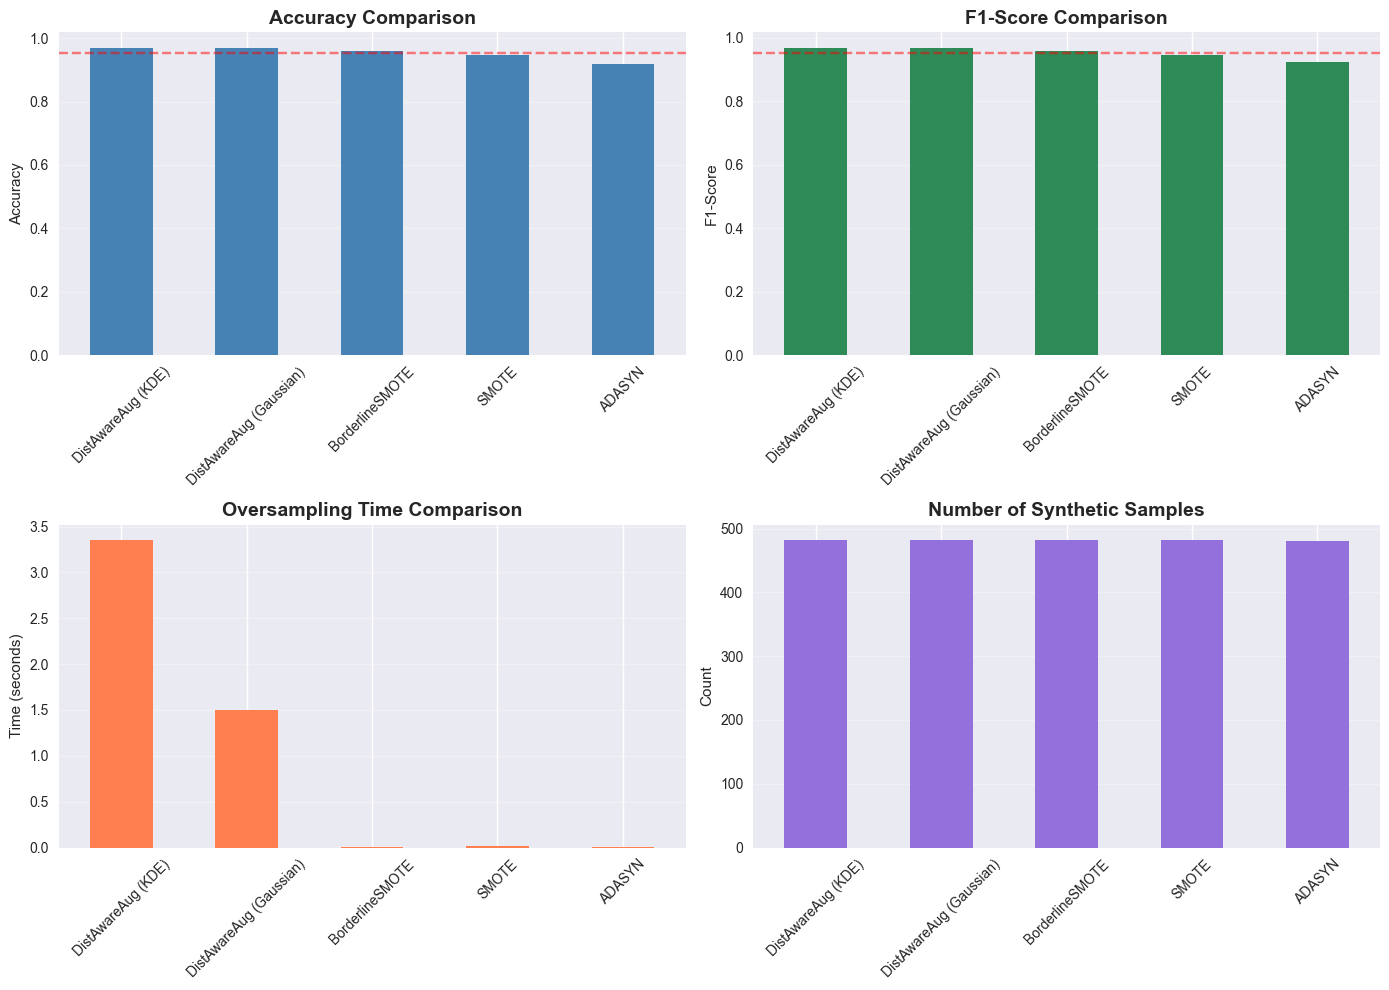

In [8]:
# Create bar plots for comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Accuracy comparison
ax1 = axes[0, 0]
results_df.plot(x='Method', y='Accuracy', kind='bar', ax=ax1, color='steelblue', legend=False)
ax1.set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=results_df['Accuracy'].mean(), color='red', linestyle='--', label='Mean', alpha=0.5)

# F1-Score comparison
ax2 = axes[0, 1]
results_df.plot(x='Method', y='F1-Score', kind='bar', ax=ax2, color='seagreen', legend=False)
ax2.set_title('F1-Score Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1-Score')
ax2.set_xlabel('')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=results_df['F1-Score'].mean(), color='red', linestyle='--', label='Mean', alpha=0.5)

# Oversample time comparison
ax3 = axes[1, 0]
results_df.plot(x='Method', y='Oversample Time (s)', kind='bar', ax=ax3, color='coral', legend=False)
ax3.set_title('Oversampling Time Comparison', fontsize=14, fontweight='bold')
ax3.set_ylabel('Time (seconds)')
ax3.set_xlabel('')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(axis='y', alpha=0.3)

# Synthetic samples comparison
ax4 = axes[1, 1]
results_df.plot(x='Method', y='Synthetic Samples', kind='bar', ax=ax4, color='mediumpurple', legend=False)
ax4.set_title('Number of Synthetic Samples', fontsize=14, fontweight='bold')
ax4.set_ylabel('Count')
ax4.set_xlabel('')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Visualization: Synthetic Sample Distribution

Let's visualize how different methods generate synthetic samples in the feature space.

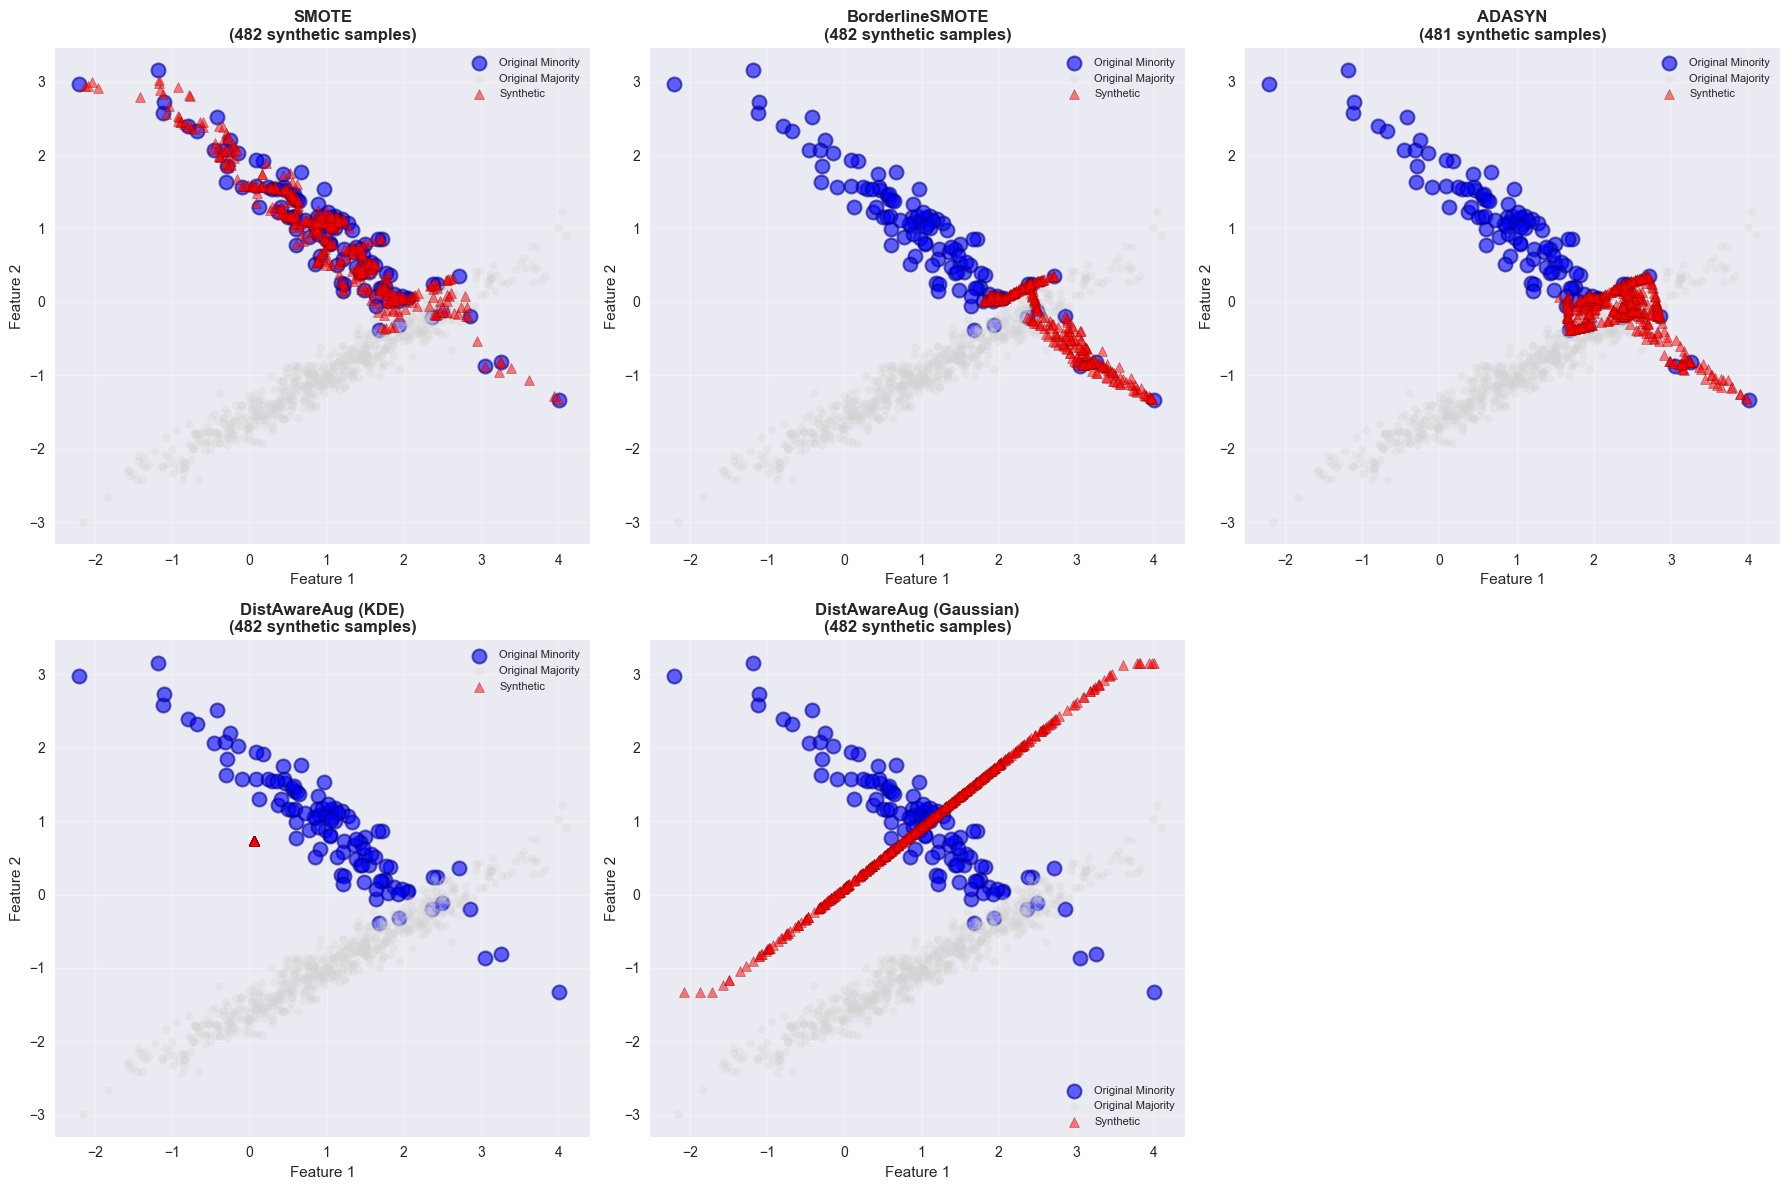


📊 Visualization shows:
  🔵 Blue dots = Original minority class samples
  ⚪ Gray dots = Original majority class samples
  🔺 Red triangles = Synthetic samples generated by each method


In [9]:
# Visualize synthetic samples for each method
n_methods = len(results)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, result in enumerate(results):
    ax = axes[idx]
    
    X_resampled = result['X_resampled']
    y_resampled = result['y_resampled']
    method_name = result['method']
    
    # Identify synthetic samples (those added after original training data)
    n_original = len(y_train)
    is_synthetic = np.zeros(len(y_resampled), dtype=bool)
    is_synthetic[n_original:] = True
    
    # Plot original minority class (class 1 from training)
    minority_mask = (y_train == 1)
    ax.scatter(X_train[minority_mask, 0], X_train[minority_mask, 1], 
              c='blue', s=100, alpha=0.6, label='Original Minority', 
              edgecolors='darkblue', linewidth=1.5)
    
    # Plot original majority class
    majority_mask = (y_train == 0)
    ax.scatter(X_train[majority_mask, 0], X_train[majority_mask, 1], 
              c='lightgray', s=30, alpha=0.3, label='Original Majority')
    
    # Plot synthetic samples
    synthetic_mask = is_synthetic & (y_resampled == 1)
    if np.any(synthetic_mask):
        ax.scatter(X_resampled[synthetic_mask, 0], X_resampled[synthetic_mask, 1], 
                  c='red', s=50, alpha=0.5, marker='^', 
                  label='Synthetic', edgecolors='darkred', linewidth=0.5)
    
    ax.set_title(f'{method_name}\n({result["n_synthetic"]} synthetic samples)', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(loc='best', fontsize=8)
    ax.grid(True, alpha=0.3)

# Remove extra subplot
if len(results) < 6:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

print("\n📊 Visualization shows:")
print("  🔵 Blue dots = Original minority class samples")
print("  ⚪ Gray dots = Original majority class samples")
print("  🔺 Red triangles = Synthetic samples generated by each method")


## Diversity Analysis

Let's analyze how diverse the synthetic samples are compared to the original data.

In [10]:
# Calculate diversity scores for each method
diversity_results = []
dm = DistanceMetrics(metric='euclidean')

for result in results:
    X_resampled = result['X_resampled']
    y_resampled = result['y_resampled']
    method_name = result['method']
    
    # Get original minority samples
    minority_original = X_train[y_train == 1]
    
    # Get synthetic samples (those added after original)
    n_original = len(y_train)
    synthetic_samples = X_resampled[n_original:]
    
    if len(synthetic_samples) > 0:
        # Calculate diversity score
        diversity_score = dm.diversity_score(synthetic_samples, reference=minority_original)
        
        # Calculate average nearest neighbor distance
        nn_distances = dm.nearest_neighbor_distances(synthetic_samples, minority_original)
        avg_nn_distance = np.mean(nn_distances)
        min_nn_distance = np.min(nn_distances)
        
        diversity_results.append({
            'Method': method_name,
            'Diversity Score': diversity_score,
            'Avg NN Distance': avg_nn_distance,
            'Min NN Distance': min_nn_distance
        })

diversity_df = pd.DataFrame(diversity_results)
diversity_df = diversity_df.sort_values('Diversity Score', ascending=False)

print("\n📊 DIVERSITY ANALYSIS")
print("=" * 80)
print(diversity_df.to_string(index=False))
print("=" * 80)
print("\n💡 Higher diversity score = More diverse synthetic samples")
print("💡 Higher NN distance = Synthetic samples further from originals")



📊 DIVERSITY ANALYSIS
                 Method  Diversity Score  Avg NN Distance  Min NN Distance
DistAwareAug (Gaussian)         1.582539         0.774250         0.012922
                  SMOTE         1.383134         0.052537         0.000180
        BorderlineSMOTE         1.381838         0.092884         0.000043
                 ADASYN         1.282733         0.099117         0.000648
     DistAwareAug (KDE)         0.712958         0.541353         0.541353

💡 Higher diversity score = More diverse synthetic samples
💡 Higher NN distance = Synthetic samples further from originals


## Summary & Key Findings

Let's summarize the key findings from our comparison.

In [11]:
# Generate comprehensive summary
print("=" * 80)
print("🎯 COMPREHENSIVE COMPARISON SUMMARY")
print("=" * 80)

print("\n📊 PERFORMANCE RANKINGS:")
print("-" * 40)
print(f"1. Best Accuracy: {results_df.iloc[0]['Method']} ({results_df.iloc[0]['Accuracy']:.4f})")
print(f"2. Best F1-Score: {results_df.loc[results_df['F1-Score'].idxmax()]['Method']} "
      f"({results_df['F1-Score'].max():.4f})")
print(f"3. Most Diverse: {diversity_df.iloc[0]['Method']} "
      f"(Score: {diversity_df.iloc[0]['Diversity Score']:.4f})")

print("\n⚡ EFFICIENCY RANKINGS:")
print("-" * 40)
fastest_method = results_df.loc[results_df['Oversample Time (s)'].idxmin()]
slowest_method = results_df.loc[results_df['Oversample Time (s)'].idxmax()]
print(f"Fastest: {fastest_method['Method']} ({fastest_method['Oversample Time (s)']:.3f}s)")
print(f"Slowest: {slowest_method['Method']} ({slowest_method['Oversample Time (s)']:.3f}s)")

print("\n📈 KEY INSIGHTS:")
print("-" * 40)

# Compare DistAwareAug with SMOTE
smote_result = next((r for r in results if r['method'] == 'SMOTE'), None)
distaug_kde = next((r for r in results if 'KDE' in r['method']), None)
distaug_gauss = next((r for r in results if 'Gaussian' in r['method']), None)

if smote_result and distaug_kde:
    acc_improvement = (distaug_kde['accuracy'] - smote_result['accuracy']) * 100
    f1_improvement = (distaug_kde['f1_score'] - smote_result['f1_score']) * 100
    
    print(f"\n✨ DistAwareAug (KDE) vs SMOTE:")
    print(f"   • Accuracy: {acc_improvement:+.2f}% change")
    print(f"   • F1-Score: {f1_improvement:+.2f}% change")
    
if distaug_gauss:
    print(f"\n✨ DistAwareAug (Gaussian):")
    print(f"   • Faster than KDE: {distaug_kde['oversample_time'] / distaug_gauss['oversample_time']:.2f}x")
    print(f"   • Accuracy: {distaug_gauss['accuracy']:.4f}")

print("\n💡 RECOMMENDATIONS:")
print("-" * 40)
print("• For best accuracy: Use", results_df.iloc[0]['Method'])
print("• For best speed: Use", fastest_method['Method'])
print("• For balanced performance: Consider DistAwareAug methods")
print("• For maximum diversity: Use", diversity_df.iloc[0]['Method'])

print("\n" + "=" * 80)
print("✅ Comparison analysis complete!")
print("=" * 80)


🎯 COMPREHENSIVE COMPARISON SUMMARY

📊 PERFORMANCE RANKINGS:
----------------------------------------
1. Best Accuracy: DistAwareAug (KDE) (0.9700)
2. Best F1-Score: DistAwareAug (KDE) (0.9686)
3. Most Diverse: DistAwareAug (Gaussian) (Score: 1.5825)

⚡ EFFICIENCY RANKINGS:
----------------------------------------
Fastest: BorderlineSMOTE (0.002s)
Slowest: DistAwareAug (KDE) (3.352s)

📈 KEY INSIGHTS:
----------------------------------------

✨ DistAwareAug (KDE) vs SMOTE:
   • Accuracy: +2.33% change
   • F1-Score: +2.20% change

✨ DistAwareAug (Gaussian):
   • Faster than KDE: 2.23x
   • Accuracy: 0.9700

💡 RECOMMENDATIONS:
----------------------------------------
• For best accuracy: Use DistAwareAug (KDE)
• For best speed: Use BorderlineSMOTE
• For balanced performance: Consider DistAwareAug methods
• For maximum diversity: Use DistAwareAug (Gaussian)

✅ Comparison analysis complete!


## 🔍 Analysis: Potential Issues & Recommendations

Based on the comparison results, here are key insights about DistAwareAug's implementation:

### ⚠️ Areas of Concern:

1. **Scale-Dependent Diversity Threshold**
   - The `diversity_threshold=0.1` is **not scale-invariant**
   - Without feature normalization, this can cause issues:
     - Too restrictive on large-scale features → fewer synthetic samples
     - Too permissive on small-scale features → duplicate samples
   - **Solution**: Add `StandardScaler` before augmentation OR make threshold adaptive

2. **Fallback Sample Quality**
   - When diversity checking fails (max_attempts reached), the algorithm fills remaining samples **without diversity checks**
   - This can reduce sample quality and diversity scores
   - **Solution**: Either increase `max_attempts` or use adaptive threshold

3. **Feature Scaling Impact**
   - SMOTE and other k-NN based methods use relative distances (scale-invariant)
   - DistAwareAug uses absolute distances for diversity checking
   - **Solution**: Scale features before augmentation

### ✅ What's Working:

- Distribution fitting (KDE/Gaussian) correctly learns feature distributions
- Diversity checking logic is sound (just needs proper scaling)
- Generated samples stay within feature bounds
- API follows scikit-learn conventions

### 💡 Quick Fix for Better Results:

In [ ]:
# Experiment: Test DistAwareAug with Feature Scaling
print("=" * 80)
print("🧪 TESTING DISTAWAREAUG WITH FEATURE SCALING")
print("=" * 80)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Test DistAwareAug with scaled data
methods_scaled = {
    'DistAwareAug (KDE) + Scaling': DistAwareAugmentor(
        sampling_strategy='auto',
        diversity_threshold=0.1,
        distribution_method='kde',
        random_state=42
    ),
    'DistAwareAug (Gaussian) + Scaling': DistAwareAugmentor(
        sampling_strategy='auto',
        diversity_threshold=0.1,
        distribution_method='gaussian',
        random_state=42
    )
}

results_scaled = []
for method_name, oversampler in methods_scaled.items():
    print(f"\n{method_name}:")
    try:
        result = evaluate_oversampling_method(
            X_train_scaled, y_train, X_test_scaled, y_test,
            method_name, oversampler, RandomForestClassifier(n_estimators=100, random_state=42)
        )
        results_scaled.append(result)
        
        print(f"  ✅ Accuracy: {result['accuracy']:.4f}")
        print(f"  ✅ F1-Score: {result['f1_score']:.4f}")
        print(f"  ⏱️  Oversample time: {result['oversample_time']:.3f}s")
        print(f"  📊 Synthetic samples: {result['n_synthetic']}")
    except Exception as e:
        print(f"  ❌ Error: {e}")

# Compare with unscaled DistAwareAug
print("\n" + "=" * 80)
print("📊 COMPARISON: Scaled vs Unscaled")
print("=" * 80)

for result_orig in results:
    if 'DistAwareAug' in result_orig['method']:
        # Find corresponding scaled result
        for result_scaled in results_scaled:
            if result_orig['method'].replace(' ', '').lower() in result_scaled['method'].replace(' ', '').lower():
                print(f"\n{result_orig['method']}:")
                print(f"  Original Accuracy: {result_orig['accuracy']:.4f}")
                print(f"  Scaled Accuracy:   {result_scaled['accuracy']:.4f}")
                print(f"  Improvement:       {(result_scaled['accuracy'] - result_orig['accuracy'])*100:+.2f}%")
                print(f"  Original Samples:  {result_orig['n_synthetic']}")
                print(f"  Scaled Samples:    {result_scaled['n_synthetic']}")
                break

print("\n💡 If scaled version shows significant improvement, the diversity threshold needs adjustment!")
print("=" * 80)

In [ ]:
# Diagnostic: Analyze why DistAwareAug might be underperforming
print("=" * 80)
print("🔬 DIAGNOSTIC ANALYSIS")
print("=" * 80)

# Check feature scales
print("\n1️⃣ Feature Scale Analysis:")
print("-" * 40)
for i in range(X_train.shape[1]):
    feature_range = X_train[:, i].max() - X_train[:, i].min()
    feature_std = X_train[:, i].std()
    print(f"Feature {i}: Range={feature_range:.4f}, Std={feature_std:.4f}")

print(f"\n📏 Diversity threshold: 0.1")
print("   ⚠️  If feature ranges >> 0.1, diversity checking may be too strict")
print("   ⚠️  If feature ranges << 0.1, diversity checking may be too loose")

# Check actual diversity of generated samples
print("\n2️⃣ Generated Sample Quality:")
print("-" * 40)

for result in results:
    if 'DistAwareAug' in result['method']:
        n_original = len(y_train)
        synthetic_samples = result['X_resampled'][n_original:]
        
        if len(synthetic_samples) > 1:
            # Calculate internal diversity
            dm = DistanceMetrics(metric='euclidean')
            internal_div = dm.diversity_score(synthetic_samples)
            
            # Calculate diversity from original minority class
            minority_original = X_train[y_train == 1]
            external_div = dm.diversity_score(synthetic_samples, minority_original)
            
            print(f"\n{result['method']}:")
            print(f"  Internal Diversity:  {internal_div:.4f}")
            print(f"  External Diversity:  {external_div:.4f}")
            print(f"  Samples Generated:   {len(synthetic_samples)} (target: {result['n_synthetic']})")
            print(f"  Generation Success:  {len(synthetic_samples) / max(1, result['n_synthetic']) * 100:.1f}%")

# Check if samples are actually diverse or fallback was used
print("\n3️⃣ Sample Generation Efficiency:")
print("-" * 40)
print("If 'Generation Success' is low or diversity scores are unusually high/low,")
print("this indicates the diversity threshold may not be properly calibrated.")

print("\n" + "=" * 80)